<a href="https://colab.research.google.com/github/ALQudahmohammad/AI/blob/main/Iris_Recognition_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## About:
In this notebook we will try to identify a personne by their iris.



## Steps:
    0. Introduction
    1. Setup the workplace
    2. Data Exploration
    3. Data Preprocessing
    4. Model selection
    5. Model Training & Evaluation
    6. Build a notebook GUI
    7. Exporting the results

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/d/d7/ColourIris.png/800px-ColourIris.png" width=50%>
<hr>

## Introduction:
**Iris recognition is an automated method of biometric identification that uses mathematical pattern-recognition techniques on video images of one or both of the irises of an individual's eyes, whose complex patterns are unique, stable, and can be seen from some distance.**

**The discriminating powers of all biometric technologies depend on the amount of entropy they are able to encode and use in matching**

### About the dataset:
Multimedia University (MMU1) database is a public database consisting of Eye Images for training models of IRIS based Biometric attendance system. IRIS patterns for each Eye are unique for every individual and this is helpful in identifying an individual. This Dataset consist of both 5 images each of left and right IRIS of 46 persons, totalling 460 images along with few empty files.

- [Dataset Link](https://www.kaggle.com/naureenmohammad/mmu-iris-dataset)

## Setup the workplace
we will start by uploading the dataset and creating necessary folders.
then importing required librarys & framworks.

In [ ]:
# uploading dataset
from google.colab import files

files.upload();

Saving IrisSeg New.zip to IrisSeg New.zip


In [ ]:
# unziping it
!unzip -q IrisSeg.zip
# creating new_folder for preprocessing images
!mkdir processed_dataset

In [ ]:
import os
import numpy as np # multidimention computation
import pandas as pd # data manipulation
import matplotlib.pyplot as plt # ploting
import cv2 as cv # image preprocessing
import tensorflow as tf # deep learning framework
import tensorflow.keras.layers as L
import warnings
from pathlib import Path # paths handling
from tensorflow.keras.preprocessing.image import ImageDataGenerator # images loading & augmentation
from tensorflow.keras.applications import EfficientNetB0 # for transfer learning
from sklearn.model_selection import train_test_split
from sklearn import metrics
from termcolor import colored # print with style
# seting some general params
%matplotlib inline
plt.rc('figure', dpi=100, figsize=(12, 6), autolayout=True)
plt.style.use("ggplot")
warnings.filterwarnings("ignore")

INF, DN = colored("[INFO]", "cyan"), colored('[DONE]', "green")
root = Path("IrisSeg")
print(DN, "Setup completed!")

[DONE] Setup completed!


**Define some constants variables.**

In [ ]:
DATA_IS_PROCESSED = True # if the data is already processed (iris extracted!)
SEED = 1997 # random seed
SIZE = (128, 128) # image size
BATCH = 32 # batch size
INPUT_SHAPE = (*SIZE, 1) # model input shape
MODEL_PATH = "Iris_Recog_model.h5"# model saving path
NEW_FOLD = "processed_dataset" # where the iris extracted images will be saved

#### For results reproduction sake will seed all random processes!

In [ ]:
def seed_everything(seed):
    """seed all random librarys"""
    np.random.seed(seed)
    tf.random.set_seed(seed)
    tf.experimental.numpy.random.seed(seed)
    print(DN, "Everything is seeded!")
    show_env()

def show_env():
    """show the important librarys versions"""
    print(INF, "Librarys Versions:")
    for lib in (np, pd, tf, cv):
        print("\t", lib.__name__, lib.__version__)

seed_everything(SEED)

[DONE] Everything is seeded!
[INFO] Librarys Versions:
	 numpy 1.22.4
	 pandas 1.4.4
	 tensorflow 2.12.0
	 cv2 4.7.0


## 2. Data Exploration

In [ ]:
print(INF, "Number of folders in the dataset folder:", len(os.listdir(root)))

[INFO] Number of folders in the dataset folder: 45


let's create some helper functions

In [ ]:
def create_dataframe(root:Path):
    """Create a dataframe from our dataset with 2 columns:
        path: image path
        class: persone name

    Args:
        root (Path): the path the folder dataset.

    Return:
        the dataset dataframe(path:str, class:str)"""
    images, classes = [], []
    for image_path in root.rglob('*.bmp'):
        images.append(str(image_path))
        class_ = image_path.parent.name.split('_')[-1]
        classes.append(class_)
    df = pd.DataFrame({"path":images, "class":classes})
    return df.sample(frac=1).reset_index(drop=True)

def read_img(path, size=None):
    """read the image from the path

    Args:
        path: image path
        size: tuple if not None will resize the image

    Return:
        image pixels in a numpy array"""
    img = cv.imread(path)
    img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    if size:
        img = cv.resize(img, size, interpolation=cv.INTER_LANCZOS4)
    return img

def show_examples(df, n):
    """show random picked examples in the dataset and display the in a grid figure.

    Args:
        df: dataset dataframe.
        n: number of examples to display (max is 25)."""
    n = min(n, 25)
    fig = plt.figure()
    samples = df.sample(n)
    i = 1
    for _, r in samples.iterrows():
        fig.add_subplot(5, 5, i)
        img = read_img(r['path'])
        plt.imshow(img, cmap="gray")
        plt.axis("off")
        plt.title(r['class'])
        i += 1
    plt.show()

In [ ]:
df = create_dataframe(root)
print(INF, "Data shape:", df.shape)
df.head()

[INFO] Data shape: (449, 2)


,path,class
0,IrisSeg/chuals/chualsl1.bmp,chuals
1,IrisSeg/kelvin/kelvinr4.bmp,kelvin
2,IrisSeg/tick/tickr2.bmp,tick
3,IrisSeg/maran/maranr4.bmp,maran
4,IrisSeg/suzaili/suzailil3.bmp,suzaili


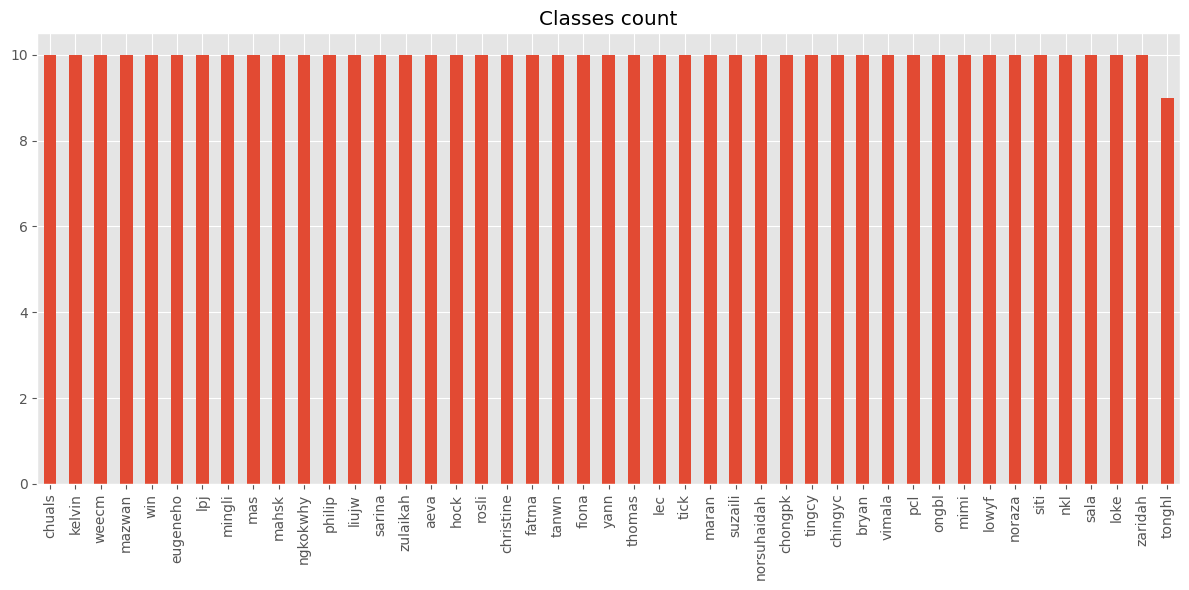

In [ ]:
df['class'].value_counts().plot.bar(title="Classes count");

In [ ]:
NUM_CLS = df['class'].nunique()
print(INF, "Number of classes:", NUM_CLS)

[INFO] Number of classes: 45


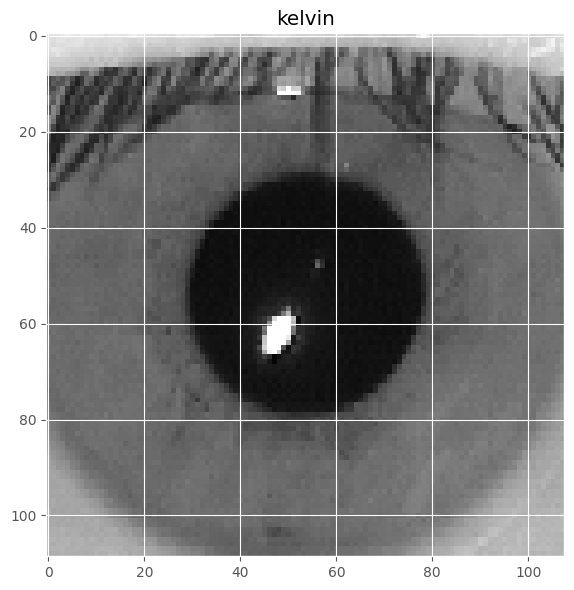

In [ ]:
i = 1
img = read_img(df.iloc[i, 0])
plt.imshow(img, cmap="gray")
plt.title(df.iloc[i, 1]);

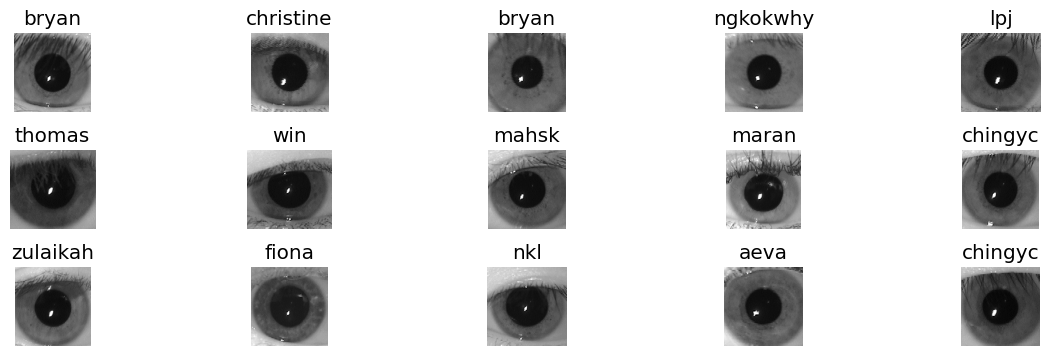

In [ ]:
show_examples(df, 15);

## 3. Data Preprocessing
I've already wrote a script to segmente the iris and upload it with the dataset in 'iris.py' file.

So we will import the IrisSegmentor class from that file -> Segment the iris and save them to a directory -> performe some data augmentation.

If we uploaded the preprocessed data (<code>DATA_IS_PROCESSED=True</code>) then we will skip the preprocessing phase.

In [ ]:
from iris import IrisSegmentor

if not DATA_IS_PROCESSED:
    segmentor = IrisSegmentor(str(root)) # we just pass it the dataset folder
    segmentor.segment_and_save(NEW_FOLD) # the we pass to saving_dir where the images will be saved
    # lets create a new dataframe for the preprocessed data
    data = create_dataframe( Path(NEW_FOLD) )
    show_examples(data, 15)
    data.head()
else:
    data = df.copy()

In [ ]:
# some sanity check:
print(DN, "Test passed:", sorted(data['class'].unique()) == sorted(df['class'].unique()) and df.shape[0] == data.shape[0])

[DONE] Test passed: True


Spliting the data to train/validation set with 20% and stratify with 'class' to keep the same number of classes in each set

In [ ]:
train, test = train_test_split(df, test_size=0.25, stratify=df['class'], random_state=SEED)

In [ ]:
def preprocess(gray):
    """pre-processing function. performe grayscale histograme equalization then
    rescale the data to range[0, 1], before feeding it the model.

    Args:
        gray: images pixels array. should be in grayscale"""

    # ATTENTION: it would not work if the img is RGB!!
    gray = gray.squeeze().astype(np.uint8) # to handle ImageDataGenerator images dtype
    gray = cv.equalizeHist(gray) # normalize the image's grayscale
    gray = np.expand_dims(gray, -1)
    return gray / 255

Performe some data augmentation to prevent overfiting and increase the sample size.

we will use:

    Randome horizontal fliping.
    Randome Rotation (-15, 15) degree
    Zoom range 20% in and out
    Shear range of 20%

In [ ]:
# for training set
train_aug = ImageDataGenerator(horizontal_flip=True, rotation_range=15,
                                preprocessing_function=preprocess, zoom_range=0.2, shear_range=0.2)
# for testing set
test_aug = ImageDataGenerator(preprocessing_function=preprocess)

now we initialize the loading generator pipeline

In [ ]:
train_gen = train_aug.flow_from_dataframe(train, x_col="path", y_col="class",
                                          target_size=SIZE, color_mode="grayscale", batch_size=BATCH)
test_gen = test_aug.flow_from_dataframe(test, x_col="path", y_col="class",
                                          target_size=SIZE, color_mode="grayscale", batch_size=BATCH, interpolation="lanczos")

Found 336 validated image filenames belonging to 45 classes.
Found 113 validated image filenames belonging to 45 classes.


In [ ]:
next(train_gen)[0].shape # should be (BATCH, SIZE[0], SIZE[1], Num_of_channels)

(32, 128, 128, 1)

## 4. Model Building

for our model archtecture we will use a simple superfeciel model, to avoid overfiting, with 3 Conv2D layers + MaxPooling to extract features then single dense layer as classifier.

In [ ]:
def simple_cnn(in_shape):

    model = tf.keras.Sequential( name="iris_recognition" )
    # input layer
    model.add(L.Input(in_shape))
    # convulotion layers
    # 32 x (3, 3) -> ReLU -> BatchNorm -> MaxPool
    model.add(L.Conv2D(32, (3, 3), padding="same"))
    model.add(L.Activation("relu"))
    model.add(L.BatchNormalization())
    model.add(L.MaxPooling2D(pool_size=(3, 3)))

    # 64 x (3, 3) -> ReLU -> BatchNorm -> MaxPool
    model.add(L.Conv2D(64, (3, 3), padding="same"))
    model.add(L.Activation("relu"))
    model.add(L.BatchNormalization())
    model.add(L.MaxPooling2D(pool_size=(2, 2)))

    # 128 x (3, 3) -> ReLU -> BatchNorm -> MaxPool
    model.add(L.Conv2D(128, (3, 3), padding="same"))
    model.add(L.Activation("relu"))
    model.add(L.BatchNormalization())
    model.add(L.MaxPooling2D(pool_size=(2, 2)))
    # flatten the features map
    model.add(L.Flatten())

    # fully connected layer
    # connect the extracted features to dense layer for classification
    model.add(L.BatchNormalization())
    model.add(L.Dense(NUM_CLS))
    model.add(L.Activation("softmax")) # output layer softmax for outputing probabilities
    opt = tf.optimizers.Adam(0.001) # adam optimizer with 0.001 learning rate
    loss = "categorical_crossentropy" # loss for multiclass classfifcation
    model.compile(optimizer=opt, loss=loss, metrics=['accuracy'])
    return model

In [ ]:
tf.keras.backend.clear_session() # to reset the tensorflow session

model = simple_cnn((*SIZE, 1))

model.summary()

Model: "iris_recognition"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      320       
                                                                 
 activation (Activation)     (None, 128, 128, 32)      0         
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 42, 42, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 42, 42, 64)        18496     
                                                                 
 activation_1 (Activation)   (None, 42, 42, 64)   

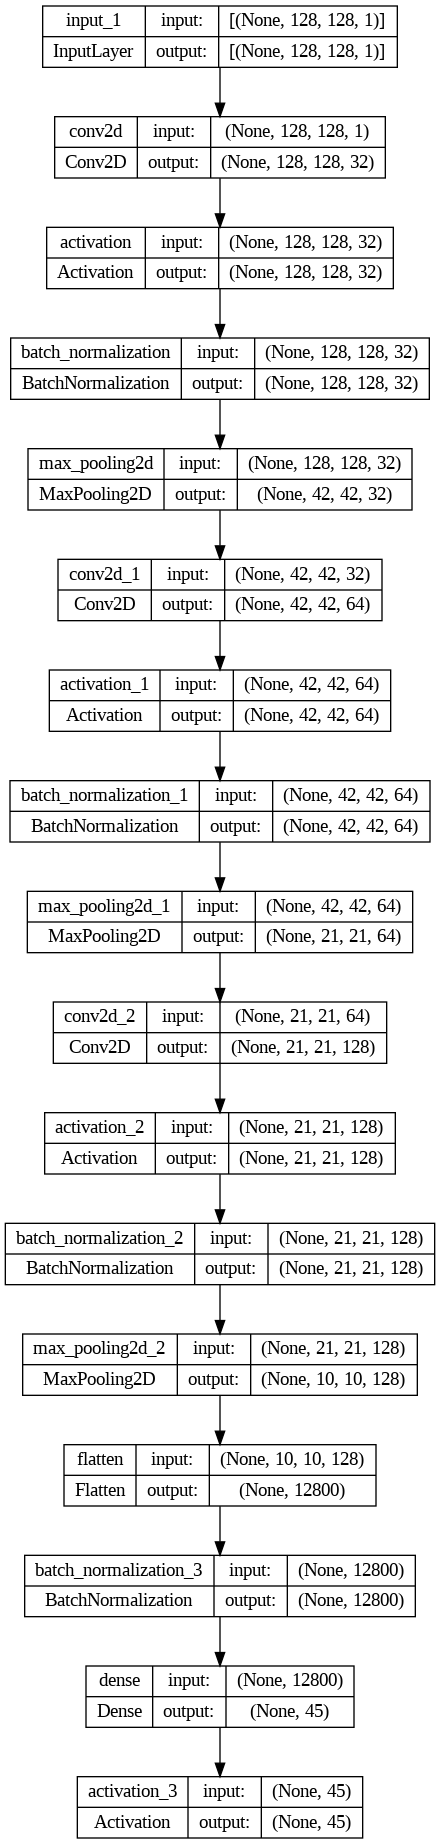

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True) # plot our model architect

## 5. Model Training & Evaluation:

we will train our model for 200 epochs, and save it on the best epoch!

In [ ]:
train_steps = train_gen.n // BATCH # how many steps to take in batch (train set)
test_steps = test_gen.n // BATCH # how many steps to take in batch (test set)

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(MODEL_PATH, save_best_only=True), # saves the model to hdd in when the loss is the lowest (accuracy highest)
    tf.keras.callbacks.ReduceLROnPlateau() # reduce the learning rate on plateau
]

EPOCHS = 200

In [ ]:
H = model.fit(train_gen, validation_data=test_gen, steps_per_epoch=train_steps,
              validation_steps=test_steps, callbacks=callbacks, epochs=EPOCHS)

Epoch 1/200
10/10 [==============================] - 8s 670ms/step - loss: 3.9651 - accuracy: 0.1678 - val_loss: 3.7758 - val_accuracy: 0.0312 - lr: 0.0010
Epoch 2/200
10/10 [==============================] - 6s 557ms/step - loss: 2.5705 - accuracy: 0.4211 - val_loss: 4.1856 - val_accuracy: 0.0312 - lr: 0.0010
Epoch 3/200
10/10 [==============================] - 6s 576ms/step - loss: 1.5320 - accuracy: 0.6250 - val_loss: 5.3133 - val_accuracy: 0.0521 - lr: 0.0010
Epoch 4/200
10/10 [==============================] - 6s 643ms/step - loss: 1.4418 - accuracy: 0.6546 - val_loss: 6.8186 - val_accuracy: 0.0208 - lr: 0.0010
Epoch 5/200
10/10 [==============================] - 6s 570ms/step - loss: 1.0794 - accuracy: 0.7664 - val_loss: 11.7248 - val_accuracy: 0.0208 - lr: 0.0010
Epoch 6/200
10/10 [==============================] - 6s 672ms/step - loss: 0.7480 - accuracy: 0.7829 - val_loss: 15.2398 - val_accuracy: 0.0312 - lr: 0.0010
Epoch 7/200
10/10 [==============================] - 6s 551ms/

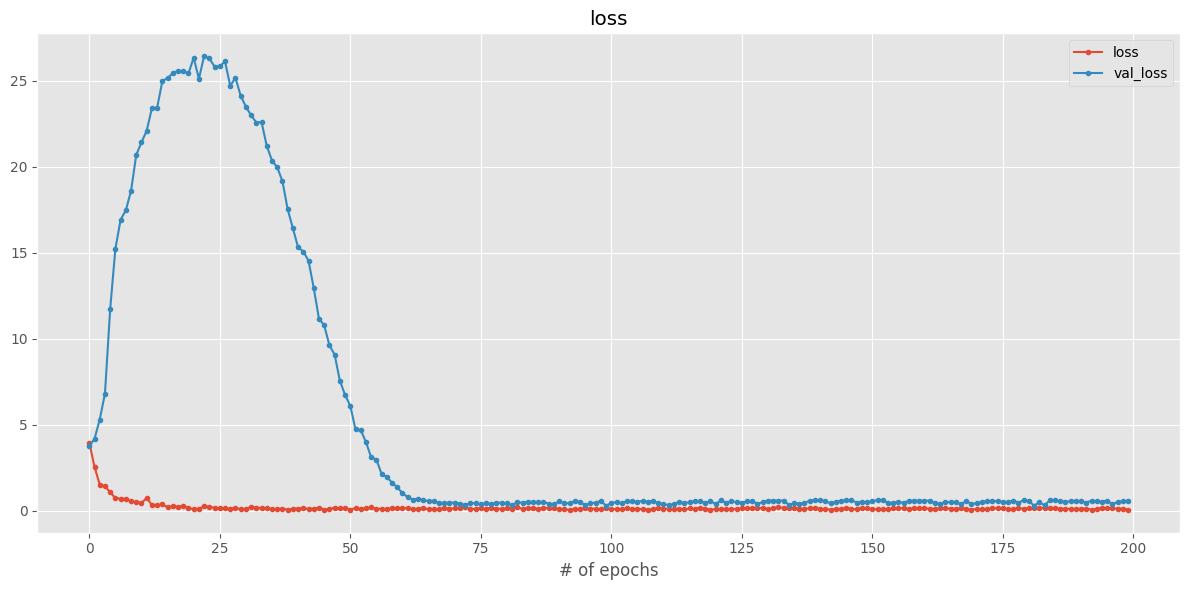

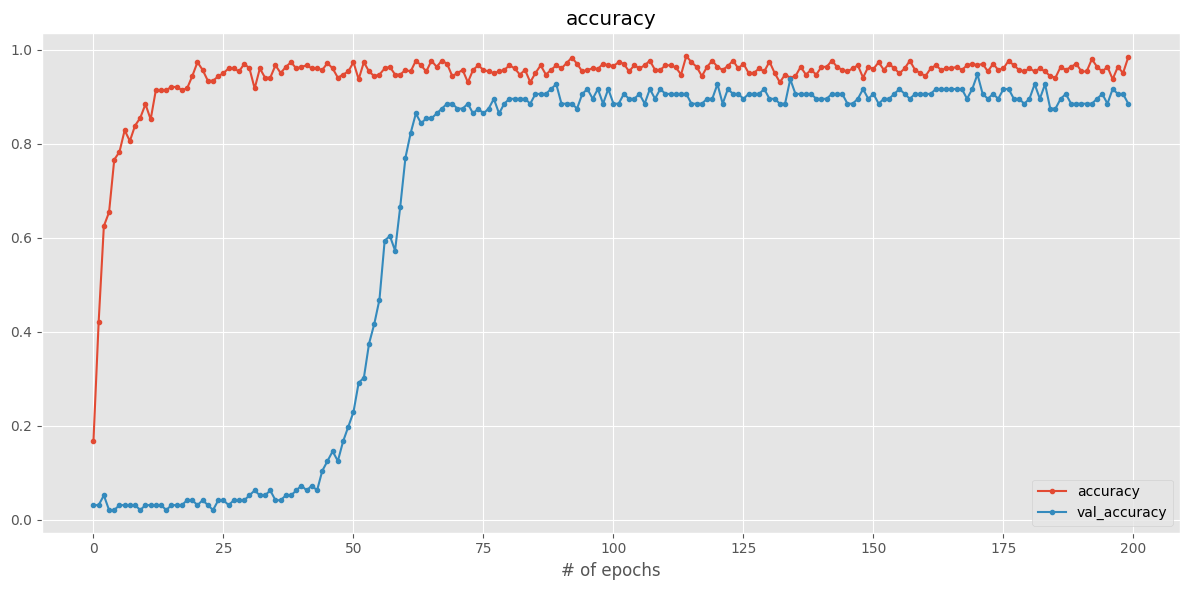

In [ ]:
h = pd.DataFrame(H.history)
for m in ['loss', "accuracy"]:
    h[[m, "val_"+m]].plot(title=m, xlabel="# of epochs", marker=".")
plt.show()

**We see that the best validation accuracy we had is 96.8% ! so the model will be save on that accuracy.**

Lets do some inference now:

In [ ]:
decoder = {v:k for k, v in train_gen.class_indices.items()} # to decode the outputed classes

In [ ]:
def process_input(img_path):
    """prepare the image to be feeded to the model"""
    if type(img_path) is str:
        img = read_img(img_path, SIZE)
        img = preprocess(img)
        ins = np.expand_dims(img, 0)
    else:
        images = []
        for img in img_path:
            img = read_img(img, SIZE)
            img = preprocess(img)
            images.append(img)
        ins = np.array(images)
    return ins

def process_output(pred, decoder):
    """decode the output of the model"""
    proba = pred.max(axis=1)[0]
    pred = pred.argmax(axis=1)[0]
    id = decoder[pred]
    return id, proba

def iris_recog_pipeline(img_path, model, decoder, show=False):
    """a pipeline that takes an image path preprocess it feed it to the model
    and decode the output then display it.

    Args:
        img_path: the image path
        model: the loaded (trained) model
        decoder: dict that containe each class and it index"""
    ins = process_input(img_path)
    pred = model.predict(ins)
    out, proba = process_output(pred, decoder)
    if show:
        plt.imshow(ins.squeeze(), cmap="gray")
        plt.title(f"Predicted person: {out}")
        plt.grid(None);plt.axis("off")
        plt.show()
        return
    return out, proba

[INFO] Testing with image 'IrisSeg/maran/maranr5.bmp', that belongs to: maran
1/1 [==============================] - 1s 533ms/step


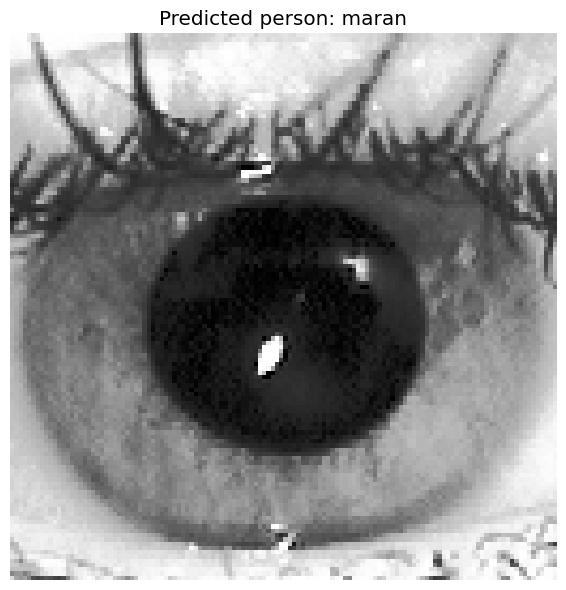

In [ ]:
i = 12# <==== just change this to select a diffrent iris from the validation set
t_path, t_cls = test.iloc[i, 0], test.iloc[i, 1]
print(INF, f"Testing with image {t_path!r}, that belongs to: {colored(t_cls, 'red', attrs=['bold'])}")
print("="*80)
iris_recog_pipeline(t_path, model, decoder, show=True)

## 6. Build a notebook GUI

Since *more complex and money consuming* to build full webpage (with backend), for displaying purposes, in this section we will try to build a notebook graphical user interface (GUI) to display our results, Using the ipywidgets library.

In [ ]:
import ipywidgets as widgets
from IPython.display import HTML, display

In [ ]:
class GUI:
    """
    a notebook gui for displaying results of the iris recognition DL model.

    Author: Iliass Benali.

    Parameters:
    -----
        @df: pandas dataframe that has "path" column containing images path.
        @prediction_func: pipeline function that takes image path, process it,
            feed it to the model and process and finaly process the output.
        @model: tensorflow trained model.
        @out_decoder: dict that maps index to classes names.
        @n: max number of files allowed to display.

    after initialization, use the init() method to display the gui.
    e.g: gui = GUI(...)
         gui.init()
    """
    def __init__(self, df, prediction_func, model, out_decoder, n=10):
        self.pred_func_args = {"model":model, "decoder":out_decoder}

        self.predict = prediction_func

        self.dropdwn = dropdown = widgets.Dropdown(
                            options= self.get_path_names(df, n),
                            description='File Name:',
                            ensure_option=True,
                            disabled=False)
        self.btn = button = widgets.Button(
                        description='Recognize the Iris',
                        disabled=False,
                        button_style='success',
                        tooltip='Identify the selected iris',
                        icon='eye')

        self.html_header = HTML("""
                <link rel="stylesheet" href="https://stackpath.bootstrapcdn.com/font-awesome/4.7.0/css/font-awesome.min.css">
        """)
        self.display_card = """
            <div class="card" style="box-shadow: 0 4px 8px 0 rgba(0,0,0,0.2);transition: 0.3s;">

                <div class="container" style="padding: 2px 16px;">
                    <hr>
                    <h4 style="color:lightgreen"><b>Predicted Personne: {pred}</b></h4>
                    <p>Confidance: {proba:.2%}</p>
                </div>
            </div>
        """

    def init(self):
        """displays the graphical user interface."""
        gui = widgets.HBox([self.dropdwn, self.btn])

        gui_output = widgets.Output()

        @gui_output.capture(clear_output=True)
        def display_prediction(e):
            path = self.dropdwn.value
            pred, proba = self.predict(path, **self.pred_func_args)
            html = self.display_card.format(pred=pred, proba=proba)
            img = read_img(path)
            display(HTML(html))
            plt.figure(figsize=(10, 5))
            plt.imshow(img, cmap="gray")
            plt.grid(None);plt.axis("off")
            plt.show()

        self.btn.on_click(display_prediction)

        return display(self.html_header, gui, gui_output)

    @staticmethod
    def get_path_names(df, n):
        """randomly select n number of images path from the dataframe"""
        return [(Path(path).name.split(".")[0], path) for path in df.path.sample(n).values]

Now to test our new Graphical user Interface.

All we have to do is Construct the gui object then call the <code>init</code> method!

In [ ]:
gui = GUI(test, iris_recog_pipeline, model, decoder, n=40)
gui.init()

Output()

## 7. Exporing the model to use offline

Since the model is automatically save on the best epoch, we wont need to exported.

We will jsut export the pipeline function, and the decoder.

for this we'll use the joblib library, and json module.

In [ ]:
import joblib
import json

In [ ]:
joblib.dump(iris_recog_pipeline, "pipline_function.func")
json.dump(decoder, open("class_decoder.json", "w"))
print(DN, "Finished exporting!")

[DONE] Finished exporting!
